### Project Files

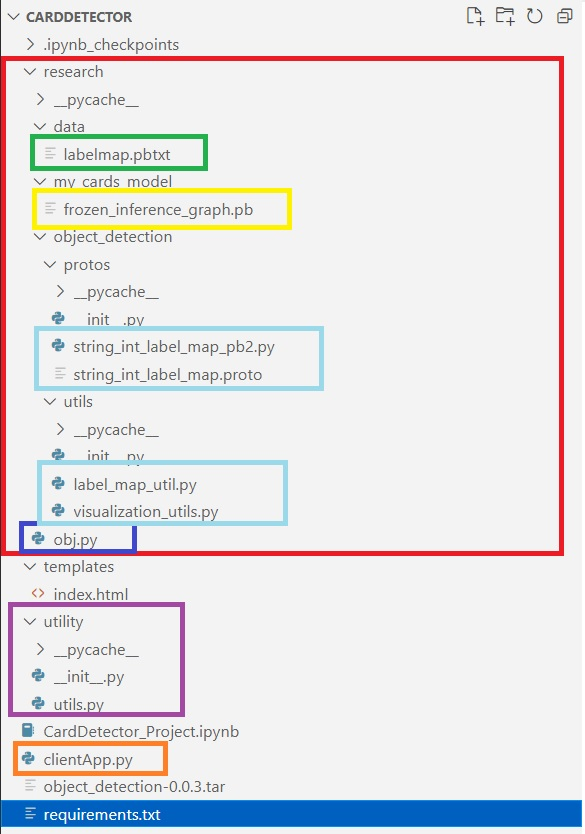

### 1. ClientApp.py

In [ ]:
from flask import Flask, request, jsonify, render_template
import os
from flask_cors import CORS, cross_origin
from utility.utils import decodeImage
from research.obj import CardsDetector

os.putenv('LANG', 'en_US.UTF-8')
os.putenv('LC_ALL', 'en_US.UTF-8')

app = Flask(__name__)
CORS(app)

# @cross_origin()
class ClientApp:
    def __init__(self):
        self.filename = "inputImage.jpg"
        modelPath = 'research/my_cards_model'
        self.objectDetection = CardsDetector(self.filename, modelPath)

@app.route("/")
def home():
    return render_template("index.html")

@app.route("/predict", methods=['POST'])
@cross_origin()
def predictRoute():
    image = request.json['image']
    decodeImage(image, clApp.filename)
    result = clApp.objectDetection.getPrediction()
    return jsonify(result)

#port = int(os.getenv("PORT"))
if __name__ == "__main__":
    clApp = ClientApp()
    port = 9000
    app.run(host='127.0.0.1', port=port)

## obj.py

In [ ]:
import os
import sys
import cv2
import numpy as np
import tensorflow as tf

from research.object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from utility.utils import encodeImageIntoBase64


class CardsDetector:
    def __init__(self, imagePath, modelPath):
        # This is needed since the notebook is stored in the object_detection folder.
        sys.path.append("..")
        # Name of the directory containing the object detection module we're using
        self.MODEL_NAME = modelPath
        self.IMAGE_NAME = imagePath
        # print(self.IMAGE_NAME)
        # Grab path to current working directory
        CWD_PATH = os.getcwd()
        # Path to frozen detection graph .pb file, which contains the model that is used
        # for object detection.
        self.PATH_TO_CKPT = os.path.join(CWD_PATH, self.MODEL_NAME, 'frozen_inference_graph.pb')
        # Path to label map file
        self.PATH_TO_LABELS = os.path.join(CWD_PATH, 'research/data', 'labelmap.pbtxt')
        # self.PATH_TO_LABELS = "data/labelmap.pbtxt"
        # Path to images
        self.PATH_TO_IMAGE = os.path.join(CWD_PATH, 'research', self.IMAGE_NAME)
        #print(self.PATH_TO_IMAGE)
        # Number of classes the object detector can identify
        self.NUM_CLASSES = 6

        # Load the label map.
        # Label maps map indices to category names, so that when our convolution
        # network predicts `5`, we know that this corresponds to `king`.
        # Here we use internal utility functions, but anything that returns a
        # dictionary mapping integers to appropriate string labels would be fine
        self.label_map = label_map_util.load_labelmap(self.PATH_TO_LABELS)
        self.categories = label_map_util.convert_label_map_to_categories(self.label_map,
                                                                         max_num_classes=self.NUM_CLASSES,
                                                                         use_display_name=True)
        self.category_index = label_map_util.create_category_index(self.categories)
        self.class_names_mapping = {
            1: "Nine", 2: "Ten",3: "jack", 4: "queen", 5: "King", 6:"Ace"
        }
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(self.PATH_TO_CKPT, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')

        # Define input and output tensors (i.e. data) for the object detection classifier

        # Input tensor is the image
        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')

        # Output tensors are the detection boxes, scores, and classes
        # Each box represents a part of the image where a particular object was detected
        self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')

        # Each score represents level of confidence for each of the objects.
        # The score is shown on the result image, together with the class label.
        self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')

        # Number of objects detected
        self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')

    def getPrediction(self):
        # Load the Tensorflow model into memory.
        # Load image using OpenCV and
        # expand image dimensions to have shape: [1, None, None, 3]
        # i.e. a single-column array, where each item in the column has the pixel RGB value
        sess = tf.Session(graph=self.detection_graph)
        image = cv2.imread(self.PATH_TO_IMAGE)
        image_expanded = np.expand_dims(image, axis=0)
        # Perform the actual detection by running the model with the image as input
        (boxes, scores, classes, num) = sess.run(
            [self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],
            feed_dict={self.image_tensor: image_expanded})

        result = scores.flatten()
        res = []
        for idx in range(0, len(result)):
            if result[idx] > .40:
                res.append(idx)

        top_classes = classes.flatten()
        # Selecting class 2 and 3
        # top_classes = top_classes[top_classes > 1]
        res_list = [top_classes[i] for i in res]

        class_final_names = [self.class_names_mapping[x] for x in res_list]
        top_scores = [e for l2 in scores for e in l2 if e > 0.30]
        # final_output = list(zip(class_final_names, top_scores))

        # print(final_output)

        # new_classes = classes.flatten()
        new_scores = scores.flatten()

        new_boxes = boxes.reshape(300, 4)

        # get all boxes from an array
        max_boxes_to_draw = new_boxes.shape[0]
        # this is set as a default but feel free to adjust it to your needs
        min_score_thresh = .30
        # iterate over all objects found
        # boundingBox = {}
        # for i in range(min(max_boxes_to_draw, new_boxes.shape[0])):
        #     if new_scores is None or new_scores[i] > min_score_thresh:
        #         boundingBox[class_final_names[i]] = new_boxes[i]
        #         print("Bounding Boxes of", class_final_names[i], new_boxes[i])

        listOfOutput = []
        for (name, score, i) in zip(class_final_names, top_scores, range(min(max_boxes_to_draw, new_boxes.shape[0]))):
            valDict = {}
            valDict["className"] = name
            valDict["confidence"] = str(score)
            if new_scores is None or new_scores[i] > min_score_thresh:
                val = list(new_boxes[i])
                valDict["yMin"] = str(val[0])
                valDict["xMin"] = str(val[1])
                valDict["yMax"] = str(val[2])
                valDict["xMax"] = str(val[3])
                listOfOutput.append(valDict)
        # new_boxes = boxes.reshape(100,4)
        # print(new_boxes)
        # print(type(new_boxes))
        # print(new_boxes.shape)
        # print(boxes.shape)
        # Draw the results of the detection (aka 'visulaize the results')

        vis_util.visualize_boxes_and_labels_on_image_array(
            image,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            self.category_index,
            use_normalized_coordinates=True,
            line_thickness=8,
            min_score_thresh=0.60)
        output_filename = 'output4.jpg'
        cv2.imwrite(output_filename, image)
        opencodedbase64 = encodeImageIntoBase64("output4.jpg")
        # json_image = dict(zip(img_dict, image_64_encode_list))
        # print(open_output_image)
        # plt.savefig(PATH + '\\' + arr.split('.')[0] + '_labeled.jpg')
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        #
        # # All the results have been drawn on image. Now display the image.
        # cv2.imshow('Object detector', image)
        #
        # # Press any key to close the image
        # cv2.waitKey(0)
        #
        # # Clean up
        # cv2.destroyAllWindows()
        listOfOutput.append({"image": opencodedbase64.decode('utf-8')})
        return listOfOutput


### labelmap.txt

item {
  id: 1
  name: 'nine'
}

item {
  id: 2
  name: 'ten'
}

item {
  id: 3
  name: 'jack'
}

item {
  id: 4
  name: 'queen'
}

item {
  id: 5
  name: 'king'
}

item {
  id: 6
  name: 'ace'
}


### Index.html

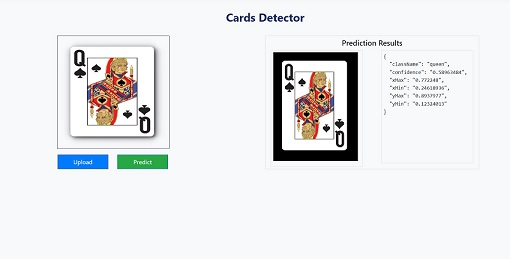